## Teks Summarisation Using Deep Learning for Analyze Customer Review of Amazon Fine Food Products

### Kelompok
Anggota 1 : Muhammad Hussein 201710370311191
<br>
Anggota 2 : Moch. Chamdani Mustaqim 201710370311285

# **Permasalahan Yang Kami Angkat**

Ulasan dari pelanggan seringkali panjang dan deskriptif. Dengan menganalisis ulasan ini secara manual benar-benar memakan waktu. Di sinilah kelebihan **Pemrosesan Bahasa Alami** dapat diterapkan untuk menghasilkan ringkasan untuk ulasan yang panjang.

Kami di sini menggunakan dataset ulasan pelanggan Amazon Fine Food. Tujuan kami adalah untuk menghasilkan ringkasan ulasan pelanggan Amazon Fine Food menggunakan pendekatan berbasis deep learning.

<br>

# **Custom Attention Layer**

Keras tidak secara resmi mendukung Attention Layer. Jadi, kami mengimplementasikan Attention Layer dari github public. Kami mengunduh Attention Layer dari [sini](https://github.com/thushv89/attention_keras/blob/master/layers/attention.py) kemudian menyalin dan menyimpannya di file berbeda bernama attention.py.

# Mount Google Drive dan Upload file attention.py

In [1]:
import attention 
from attention import AttentionLayer

# Impor Library

In [2]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Read dataset

Dataset ini terdiri dari ulasan makanan enak dari Amazon. Data ini mencakup periode lebih dari 10 tahun, termasuk semua ~ 500.000 ulasan hingga Oktober 2012. Ulasan ini mencakup produk dan informasi pengguna, peringkat, ulasan teks biasa, dan ringkasan. Ini juga termasuk ulasan dari semua kategori Amazon lainnya.

Kami akan mengambil sampel 100.000 ulasan untuk mengurangi waktu pelatihan model kami. Jangan ragu untuk menggunakan seluruh dataset untuk melatih model Anda jika mesin Anda memiliki kekuatan komputasi semacam itu.

In [3]:
# data=pd.read_csv(path+"Reviews.csv",nrows=100000)
data=pd.read_csv("Reviews.csv")

In [4]:
data.shape

(568454, 10)

# Drop Duplicates dan NA values

In [5]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na
data.shape

(393565, 10)

# Informasi tentang dataset

Mari kita lihat tipe data dan bentuk dataset

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393565 entries, 0 to 568453
Data columns (total 10 columns):
Id                        393565 non-null int64
ProductId                 393565 non-null object
UserId                    393565 non-null object
ProfileName               393565 non-null object
HelpfulnessNumerator      393565 non-null int64
HelpfulnessDenominator    393565 non-null int64
Score                     393565 non-null int64
Time                      393565 non-null int64
Summary                   393565 non-null object
Text                      393565 non-null object
dtypes: int64(5), object(5)
memory usage: 33.0+ MB


#Preprocessing

Melakukan langkah-langkah Preprocessing dasar sangat penting sebelum kami sampai pada bagian pembuatan model. Menggunakan data teks yang tidak beraturan dan tidak bersih adalah langkah yang berpotensi menimbulkan bencana dalam pemrosesan bahasa alami. Jadi pada langkah ini, kami akan membuang semua simbol, karakter, dll yang tidak diinginkan dari teks yang tidak mempengaruhi tujuan masalah yang kami angkat.

Berikut ini adalah kamus yang akan kami gunakan untuk memperluas kontraksi:

In [7]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

### **Download stopwords dari library nltk**

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Kami akan melakukan sedikit pemrosesan awal untuk data kami:

1. Konversikan semuanya menjadi huruf kecil

2. Hapus tag HTML

3. Pemetaan kontraksi

4. Hapus (‘s)

5. Hapus teks apa pun di dalam tanda kurung ()

6. Hilangkan tanda baca dan karakter khusus

7. Hapus stopwords

8. Hapus kata-kata pendek

berikut fungsi yang kami gunakan:

In [9]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 # menghapus kata - kata pendek
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [10]:
#memanggil fungsi
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

### **Melihat ulasan 5 pelanggan**

In [11]:
cleaned_text[:5]  

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [12]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

### **Melihat 10 ringkasan pertama yang telah dilakukan preprocessing**

In [13]:
cleaned_summary

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food',
 'the best hot sauce in the world',
 'my cats love this diet food better than their regular food',
 'my cats are not fans of the new food',
 'fresh and greasy',
 'strawberry twizzlers yummy',
 'lots of twizzlers just what you expect',
 'poor taste',
 'love it',
 'great sweet candy',
 'home delivered twizlers',
 'always fresh',
 'twizzlers',
 'delicious product',
 'twizzlers',
 'please sell these in mexico',
 'twizzlers strawberry',
 'nasty no flavor',
 'great bargain for the price',
 'yummy',
 'great machine',
 'this is my taste',
 'best of the instant oatmeals',
 'good instant',
 'great irish oatmeal for those in hurry',
 'satisfying',
 'love gluten free oatmeal',
 'it is oatmeal',
 'good way to start the day',
 'wife favorite breakfast',
 'why would not you

In [14]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

# Drop empty rows

In [15]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)
data.shape

(393213, 12)

# Memahami distribusi kata dari urutan ulasan

Di sini, kami akan menganalisis panjang ulasan dan ringkasan untuk mendapatkan ide keseluruhan tentang distribusi panjang teks. Ini akan membantu kami memperbaiki panjang maksimum urutan ulasan:

In [16]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# mengisi list dengan panjang kalimat
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
# plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000216E71E9348>,
      dtype=object)

Kami di sini dapat memperbaiki panjang maksimum ringkasan hingga 8 karena itu tampaknya menjadi panjang ringkasan mayoritas.

kami mencoba memahami proporsi panjang ringkasan di bawah 8

In [17]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9458130834941876


Kami mengamati bahwa 94% dari ringkasan memiliki panjang di bawah 8. Jadi, kami dapat memperbaiki panjang maksimum ringkasan ke 8.

Mari kita perbaiki panjang tinjauan maksimum menjadi 30

In [18]:
max_text_len=30
max_summary_len=8

Selanjutnya kami memilih ulasan dan ringkasan yang panjangnya di bawah atau sama dengan **max_text_len** dan **max_summary_len**

In [19]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

Untuk menambahkan **START** dan **END** token khusus di awal dan akhir ringkasan. Di sini, kami telah memilih **sostok** dan **eostok** sebagai token START dan END

Sebelumnya kami memastikan bahwa token khusus yang dipilih tidak pernah muncul dalam ringkasan

In [20]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

Sebelum kami membangun model, kami perlu membagi dataset kami menjadi set train dan validation. Kami akan menggunakan porsi 90% dari dataset sebagai data train dan 10% yang tersisa sebagai data validation (set holdout):

In [21]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

# Mempersiapkan Tokenizer

Tokenizer membangun kosakata dan mengubah urutan kata menjadi urutan bilangan bulat. Membuat tokenizer untuk teks dan ringkasan:

# Text Tokenizer

In [22]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#mempersiapkan tokenizer untuk ulasan pada data training
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

# Kata - Kata Langka dan Cakupannya

Melihat proporsi kata-kata langka dan cakupan totalnya di seluruh teks

Di sini, kami mendefinisikan threshold menjadi 4 yang berarti kata yang hitungnya di bawah 4 dianggap sebagai kata yang langka

In [23]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% kata-kata langka dalam kosa kata:",(cnt/tot_cnt)*100)
print("Cakupan total kata-kata langka:",(freq/tot_freq)*100)

% kata-kata langka dalam kosa kata: 68.11028647495395
Cakupan total kata-kata langka: 1.4450730144421176


**Sebagai catatan kami**:


* **tot_cnt** memberikan ukuran kosakata (yang berarti setiap kata unik dalam teks)
 
* **cnt** memberi kami no. kata-kata langka yang jumlahnya di bawah ambang batas

* **tot_cnt - cnt** memberi kami kata paling umum

Selanjutnya kami mendefinisikan tokenizer dengan kata-kata paling umum untuk ulasan.

In [24]:
# menyiapkan tokenizer untuk ulasan tentang data pelatihan
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# ubah urutan teks ke dalam urutan integer
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

# padding nol hingga panjang maksimum
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# ukuran kosakata (+1 untuk padding token)
x_voc   =  x_tokenizer.num_words + 1

In [25]:
x_voc

17489

# Summary Tokenizer

In [26]:
# menyiapkan tokenizer untuk ulasan tentang data training
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

# Kata - Kata Langka dan Cakupannya

Mari kita lihat proporsi kata-kata langka dan cakupan totalnya di seluruh ringkasan

Di sini, kami mendefinisikan treshold menjadi 6 yang berarti kata yang hitungnya di bawah 6 dianggap sebagai kata yang langka

In [27]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% kata-kata langka dalam kosa kata:",(cnt/tot_cnt)*100)
print("Cakupan total kata-kata langka:",(freq/tot_freq)*100)

% kata-kata langka dalam kosa kata: 75.99750324098527
Cakupan total kata-kata langka: 2.592810080219758


Selanjutnya kami akan mendefinisikan tokenizer dengan kata paling umum untuk ringkasan.

In [28]:
# menyiapkan tokenizer untuk ulasan tentang data pelatihan
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# ubah urutan teks ke dalam urutan integer
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

# beri padding nol hingga panjang maksimum
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# ukuran kosakata
y_voc  =   y_tokenizer.num_words +1

Kemudian kami memeriksa apakah jumlah token awal kata sama dengan panjang data pelatihan

In [29]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(192402, 192402)

Di sini, saya menghapus baris yang hanya berisi token **START** dan **END**

In [30]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [31]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Membangun model

Step paling penting sebelum melakukan training data adalah membangun model berikut kami meringkas sedikit tentang model yang kami gunakan.

**Return Sequences = True**: Ketika parameter sequences return diatur ke True, LSTM menghasilkan status hidden dan status sel untuk setiap catatan waktu

**Return State = True**: Ketika kondisi pengembalian = True, LSTM menghasilkan status hidden dan status sel dari catatan waktu terakhir saja

**Initial State**: Ini digunakan untuk menginisialisasi status internal LSTM untuk catatan waktu pertama

**Stacked LSTM**: Tumpukan LSTM memiliki beberapa lapisan LSTM yang saling bertumpuk.

Ini mengarah pada representasi urutan yang lebih baik. Kami bisa bereksperimen dengan banyak lapisan LSTM yang ditumpuk satu sama lain.

Di sini, kami membangun LSTM 3 susun untuk pembuat encoder:

In [32]:
from tensorflow.keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output3, state_h3, state_c3= encoder_lstm3(encoder_output2)

#encoder lstm 4
encoder_lstm4=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output4, state_h4, state_c4= encoder_lstm4(encoder_output3)

#encoder lstm 5
encoder_lstm5=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.2,recurrent_dropout=0.2)
encoder_output5, state_h5, state_c5= encoder_lstm5(encoder_output4)

#encoder lstm 6
encoder_lstm6=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.2,recurrent_dropout=0.2)
encoder_output6, state_h6, state_c6= encoder_lstm6(encoder_output5)

#encoder lstm 7
encoder_lstm7=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.2,recurrent_dropout=0.2)
encoder_outputs, state_h, state_c= encoder_lstm7(encoder_output6)

# Membuat decoder, using `encoder_states` sebagai initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Menggabungkan attention input dan decoder output LSTM
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# mendefinisikan model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      1748900     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 30, 300), (N 721200      lstm[0][0]                       
______________________________________________________________________________________________

Kami di sini menggunakan `sparse_categorical_crossentropy` sebagai fungsi loss karena fungsi tersebut mengubah urutan integer ke vektor one-hot dengan cepat. Dan menurut literatur hal mengatasi dapat masalah memori.

In [33]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Konsep `EarlyStopping` kami digunakan untuk menghentikan training jaringan saraf yang kami buat pada waktu yang tepat dengan parameter metrik yang kami tentukan. Di sini kami menggunakan validation loss (val_loss) sebagai parameter `EarlyStopping` yang kami buat. Model kami akan menghentikan proses training setelah validation loss meningkat:

In [34]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2,patience=2)

In [35]:
from IPython.display import display
# from PIL import Image
import time

Step terakhir adalah training model pada ukuran batch 128 dan memvalidasinya pada set holdout (yang merupakan 10% dari dataset kami):

In [36]:
start_time = time.time() 
history=model.fit([x_tr,y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0],
                               y_tr.shape[1],
                               1)[:,1:] ,
                  epochs=50,
                  callbacks=[es],
                  # verbose=2,
                  batch_size=128, 
                  validation_data=([x_val,y_val[:,:-1]], 
                                   y_val.reshape(y_val.shape[0],
                                                 y_val.shape[1], 
                                                 1)[:,1:]))
stop_time = time.time()

Train on 189522 samples, validate on 21051 samples
Epoch 1/50
189522/189522 [==============================] - 433s 2ms/sample - loss: 2.7479 - val_loss: 2.5118
Epoch 2/50
189522/189522 [==============================] - 419s 2ms/sample - loss: 2.4512 - val_loss: 2.3625
Epoch 3/50
189522/189522 [==============================] - 419s 2ms/sample - loss: 2.3494 - val_loss: 2.2909
Epoch 4/50
189522/189522 [==============================] - 419s 2ms/sample - loss: 2.2900 - val_loss: 2.2446
Epoch 5/50
189522/189522 [==============================] - 419s 2ms/sample - loss: 2.2450 - val_loss: 2.2114
Epoch 6/50
189522/189522 [==============================] - 416s 2ms/sample - loss: 2.2115 - val_loss: 2.1812
Epoch 7/50
189522/189522 [==============================] - 416s 2ms/sample - loss: 2.1872 - val_loss: 2.1572
Epoch 8/50
189522/189522 [==============================] - 417s 2ms/sample - loss: 2.1637 - val_loss: 2.1396
Epoch 9/50
189522/189522 [==============================] - 420s 2ms/

In [37]:
print('Runtime training model: %.2fs' % (stop_time - start_time))

Runtime training model: 13409.70s


# Memahami plot Diagnostik

Sekarang, kami akan memplot beberapa plot diagnostik untuk memahami hasil pembelajaran model dari waktu ke waktu:

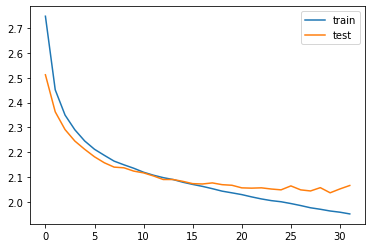

In [38]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Dari plot, kami dapat menyimpulkan bahwa val_loss telah meningkat setelah epoch 17 selama 2 epoch berturut-turut. Karenanya, pelatihan dihentikan pada epoch 19.

Selanjutnya, kami membuat kamus untuk mengonversi indeks ke kata untuk kosakata target dan sumber:

In [39]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

Siapkan inferensi untuk pembuat enkode dan dekoder:

In [40]:
# Encode urutan input untuk mendapatkan vektor fitur
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Di bawah ini tensor akan menahan state langkah waktu sebelumnya
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Dapatkan embeddings dari urutan decoder
dec_emb2= dec_emb_layer(decoder_inputs) 

# Untuk memprediksi kata berikutnya dalam urutan, 
# atur status awal ke status dari langkah waktu sebelumnya
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Lapisan softmax yang padat untuk menghasilkan masalah. atas kosakata target
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

Kami mendefinisikan fungsi di bawah ini yang merupakan implementasi dari proses inferensi

In [41]:
def decode_sequence(input_seq):
    # Mengkodekan input sebagai vektor keadaan.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Hasilkan urutan target kosong yang panjangnya 1.
    target_seq = np.zeros((1,1))
    
    # Populasikan kata pertama dari urutan target dengan kata awal.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sampling token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Kondisi Exit: baik mencapai panjang max atau temukan kata berhenti.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Perbarui urutan target (dengan panjang 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Perbarui internal states
        e_h, e_c = h, c

    return decoded_sentence

Mendefinisikan fungsi untuk mengubah urutan bilangan bulat menjadi urutan kata untuk ringkasan serta ulasan:

In [42]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Berikut adalah beberapa ringkasan yang dihasilkan oleh model yang telah kami buat:

In [43]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))    
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: great think might even better regular brownies good happy found 
Original summary: so good 
Predicted summary:  great brownies


Review: candies soft soft pepermint means melt mouth bite break apart bad sad buy another kind soft peppermint next go around 
Original summary: soft 
Predicted summary:  good candy


Review: love bob red mill products grains blend ground included multigrain bread without grinding home pantry staple house price fantastic 
Original summary: makes great multigrain bread 
Predicted summary:  great product


Review: think product excellent came quickly used almost buy 
Original summary: excellent product 
Predicted summary:  great product


Review: quality extract unbelievable results great everyone always says something different makes results better 
Original summary: cake cookies pies 
Predicted summary:  great product


Review: recently started baking bread yeast perfect rises consistantly every time held great frozen 
Original summary: great for brea

Predicted summary:  great product


Review: enjoy kind bars especially non fruit bars agrees stomach sensitivies store bought products important bars satisfies cravings something sweet without making sick good flavor sea salt one different 
Original summary: excellent snack 
Predicted summary:  great snack


Review: happy finally found reasonable price since also pack know look time soon product exactly expected phenomenal sushi remember enjoy 
Original summary: just as expected 
Predicted summary:  great service


Review: came across local grocery store grabbed bottle fruit punch tried long tried every flavor mango peach favorite flavor one exceptionally good 
Original summary: yummy 
Predicted summary:  refreshing


Review: make coffee really love great flavors add scoop equal exchange hot drizzle raw honey make perfect mocha 
Original summary: mm 
Predicted summary:  great coffee


Review: product arrived quickly treats fresh definitely order dogs run treats low cal added bonus 
Ori

Predicted summary:  cat food


Review: nice coffee chocolately hint would def buy wondeful coffee beautiful aroma 
Original summary: lovely 
Predicted summary:  coffee


Review: terrific easy way grow fresh herbs kitchen mess garden growing month ready harvest soon company support superb one seed pod germinate within week replaced 
Original summary: great product 
Predicted summary:  great product


Review: question pickled sausages hearts ingredient freakin disgusting 
Original summary: yuck 
Predicted summary:  gross


Review: salty cut equal amount water surprised still plenty flavor 
Original summary: something new 
Predicted summary:  salty


Review: chocolate fresh delicious tastes exactly like ones buy europe love bounty love coconuts definitely satisfy cravings buy seller 
Original summary: yummy 
Predicted summary:  delicious


Review: recently amazing watermelon licorice traveling could find brand online thought would try one flavor good licorice stale think even able eat 
Or

# **Kesimpulan**

Ini hal yang cukup bagus. Meskipun ringkasan aktual dan ringkasan yang dihasilkan oleh model kami tidak cocok dalam hal kata-kata, keduanya menyampaikan makna yang sama. Model kami mampu menghasilkan ringkasan yang dapat dibaca berdasarkan konteks yang ada dalam teks.

Ini adalah bagaimana model kami dapat melakukan peringkasan teks menggunakan konsep deep learning dengan Python.

In [45]:
model.save('NLP_8LSTM_FullData_trial2.h5')
model.save_weights('NLP_8LSTM_FullData_weights_trial2.h5')